# Coding: Machine Translation (RNN + Attention)

 - Dataset: wmt-17, en-zh, select 1m high-quality pairs of data
 - Model: Seq2seq with RNN + Attention
 - GPU: 4090

In [1]:
# Download the data & select 5m high-quality pairs

from datasets import load_dataset
import re

# load full wmt-17 en-zh dataset
full_dataset = load_dataset("wmt/wmt17", "zh-en", split="train")

# Length & Ratio filter
def is_high_quality(x):
    en = x["translation"]["en"]
    zh = x["translation"]["zh"]
    if not en or not zh:
        return False
    if len(en) < 3 or len(zh) < 3:
        return False
    if len(en) > 100 or len(zh) > 100:
        return False
    ratio = len(en) / len(zh)
    if ratio < 0.5 or ratio > 2:
        return False
    if not re.search(r'[\u4e00-\u9fff]', zh):
        return False
    return True

filtered_dataset = full_dataset.filter(is_high_quality, num_proc=10)

dataset = filtered_dataset.select(range(min(5_000_000, len(filtered_dataset))))

print("Full Dataset Size: ", len(full_dataset))
print("Filtered Dataset Size: ", len(filtered_dataset))
print("Dataset Size: ", len(dataset))

# print 10 samples
sample = dataset.shuffle(seed=42).select(range(10))
print("-"*100)
for i in sample:
    print(i["translation"]["en"])
    print(i["translation"]["zh"])
    print("-"*100)

/home/archer/archer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Full Dataset Size:  25134743
Filtered Dataset Size:  1141860
Dataset Size:  1141860
----------------------------------------------------------------------------------------------------
Zambia (7)
赞比亚(7)
----------------------------------------------------------------------------------------------------
15:00 to 18:00 Informal consultations (closed) Conference Room 5 (NLB)
下午3:00－6:00 非正式磋商(闭门会议) 第5会议室(北草坪会议大楼)
----------------------------------------------------------------------------------------------------
Spain
西班牙
----------------------------------------------------------------------------------------------------
Mr. Robert Morrison
Robert Morrison先生 加拿大自然资源部
----------------------------------------------------------------------------------------------------
This satisfied the kids, but not the husband.
"孩子们得到了满意的答案, 但她的丈夫却没有。
----------------------------------------------------------------------------------------------------
Shutaro Omura (Japan)
Shutaro Omura（日本）
---------------

In [2]:
# Create PyTorch Dataset and DataLoader for training

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer_en, tokenizer_zh, max_length=100):
        """
        PyTorch Dataset wrapper for HuggingFace translation dataset
        
        Args:
            hf_dataset: HuggingFace dataset with translation pairs
            tokenizer_en: English tokenizer (optional, can be added later)
            tokenizer_zh: Chinese tokenizer (optional, can be added later)
            max_length: Maximum sequence length
        """
        self.dataset = hf_dataset
        self.tokenizer_en = tokenizer_en
        self.tokenizer_zh = tokenizer_zh
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        en_text = item["translation"]["en"]
        zh_text = item["translation"]["zh"]

        en_tokens = self.tokenizer_en(en_text, 
                                        max_length=self.max_length, 
                                        padding='max_length', 
                                        truncation=True, 
                                        return_tensors='pt')
            
        zh_tokens = self.tokenizer_zh(zh_text, 
                                        max_length=self.max_length, 
                                        padding='max_length', 
                                        truncation=True, 
                                        return_tensors='pt')
            
        return {
                'source_ids': en_tokens['input_ids'].squeeze(),
                'target_ids': zh_tokens['input_ids'].squeeze(),
                'source_text': en_text,
                'target_text': zh_text
        }

def create_dataloaders(dataset, batch_size=128, num_workers=12, train_split=0.95):
    """
    Create train and validation DataLoaders from HuggingFace dataset
    
    Args:
        dataset: HuggingFace dataset with translation pairs
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for data loading
        train_split: Fraction of data to use for training
    
    Returns:
        train_dataloader, val_dataloader, train_dataset, val_dataset
    """
    
    # Split dataset into train and validation
    train_size = int(train_split * len(dataset))
    
    # Create indices for splitting
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices, 
                                                train_size=train_size, 
                                                random_state=42)
    
    # Create train and validation datasets
    train_dataset_hf = dataset.select(train_indices)
    val_dataset_hf = dataset.select(val_indices)

    # tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

    # get vocab sizes
    vocab_size_en = tokenizer_en.vocab_size
    vocab_size_zh = tokenizer_zh.vocab_size

    print(f"Vocab size for en: {vocab_size_en}")
    print(f"Vocab size for zh: {vocab_size_zh}")

    # Create PyTorch datasets
    train_dataset = TranslationDataset(train_dataset_hf, tokenizer_en, tokenizer_zh)
    val_dataset = TranslationDataset(val_dataset_hf, tokenizer_en, tokenizer_zh)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Train DataLoader: {len(train_dataloader)} batches")
    print(f"Validation DataLoader: {len(val_dataloader)} batches")
    
    return train_dataloader, val_dataloader, vocab_size_en, vocab_size_zh

def test_dataloader(dataloader):
    """Test the DataLoader by printing a sample batch"""
    print("\n" + "="*50)
    print("Sample batch from DataLoader:")
    print("="*50)
    
    for batch in dataloader:
        print(f"Batch size: {len(batch['source_text'])}")
        print(f"Source example: {batch['source_text'][0]}")
        print(f"Source tokens: {batch['source_ids'][0]}")
        print(f"Target example: {batch['target_text'][0]}")
        print(f"Target tokens: {batch['target_ids'][0]}")
        break

train_dataloader, val_dataloader, encoder_vocab_size, decoder_vocab_size = create_dataloaders(dataset)
test_dataloader(train_dataloader)
test_dataloader(val_dataloader)

Vocab size for en: 30522
Vocab size for zh: 21128
Train dataset size: 1084767
Validation dataset size: 57093
Train DataLoader: 8475 batches
Validation DataLoader: 447 batches

Sample batch from DataLoader:
Batch size: 128
Source example: He led us to a museum.
Source tokens: tensor([ 101, 2002, 2419, 2149, 2000, 1037, 2688, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Target example: 他把我们带到了一个博物馆。
Target tokens: tensor

In [3]:
# Define the Seq2Seq model with GRU + Attention

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Attention(nn.Module):
    """
    QKV Attention mechanism for Seq2Seq models
    """
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        
        # QKV transformations
        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)  # Query projection
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)  # Key projection  
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)  # Value projection
        
    def forward(self, encoder_outputs, decoder_hidden):
        """
        Compute attention weights and context vector
        
        Args:
            encoder_outputs: [batch_size, seq_len, hidden_size]
            decoder_hidden: [batch_size, hidden_size]
            
        Returns:
            context: [batch_size, hidden_size]
            attention_weights: [batch_size, seq_len]
        """
        # Q: Transform decoder hidden state
        Q = self.W_q(decoder_hidden.unsqueeze(1))  # [batch_size, 1, hidden_size]
        
        # K, V: Transform encoder outputs
        K = self.W_k(encoder_outputs)  # [batch_size, seq_len, hidden_size]
        V = self.W_v(encoder_outputs)  # [batch_size, seq_len, hidden_size]
        
        # Scaled dot-product attention
        scores = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(self.hidden_size)
        attention_weights = F.softmax(scores.squeeze(1), dim=1)
        
        # Context vector: [batch_size, hidden_size]
        context = torch.bmm(attention_weights.unsqueeze(1), V).squeeze(1)
        
        return context, attention_weights

class Encoder(nn.Module):
    """
    Encoder component of the Seq2Seq model using GRU
    Processes the input sequence and generates context vectors
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Encoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer to convert token IDs to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # GRU layer for processing sequences
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout, bidirectional=False)
        
    def forward(self, input_seq):
        """
        Forward pass of the encoder
        
        Args:
            input_seq: Input token sequences [batch_size, seq_len]
            input_lengths: Actual lengths of sequences (for packed sequences)
            
        Returns:
            outputs: All hidden states [batch_size, seq_len, hidden_size]
            hidden: Final hidden state [num_layers, batch_size, hidden_size]
        """
        
        # Convert token IDs to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]
        
        # Pass through GRU
        outputs, hidden = self.rnn(embedded)
        
        # outputs: [batch_size, seq_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size] 
        
        return outputs, hidden

class Decoder(nn.Module):
    """
    Decoder component of the Seq2Seq model using GRU with Attention
    Generates output sequence one token at a time
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer for target tokens
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # Attention mechanism
        self.attention = Attention(hidden_size)
        
        # GRU layer for generating sequences (input: embedding + context)
        self.rnn = nn.GRU(embed_size + hidden_size, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout, bidirectional=False)
        
        # Output projection layer to vocabulary (input: GRU output)
        self.output_projection = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_token, hidden, encoder_outputs):
        """
        Forward pass of the decoder with attention (single step)
        TODO: the logic of this function is inconsistent with the forward_seq function, need to fix it
        
        Args:
            input_token: Current input token [batch_size, 1]
            hidden: Hidden state from encoder/previous step [num_layers, batch_size, hidden_size]
            encoder_outputs: All encoder outputs [batch_size, seq_len, hidden_size]
            
        Returns:
            output: Vocabulary predictions [batch_size, vocab_size]
            hidden: Updated hidden state [num_layers, batch_size, hidden_size]
            attention_weights: Attention weights [batch_size, seq_len]
        """
        # input_token: [batch_size, 1]
        embedded = self.embedding(input_token)  # [batch_size, 1, embed_size]
        
        # Use the top layer hidden state for attention computation
        decoder_hidden_for_attention = hidden[-1]  # [batch_size, hidden_size]
        
        # Compute attention context
        context, attention_weights = self.attention(encoder_outputs, decoder_hidden_for_attention)
        # context: [batch_size, hidden_size]
        # attention_weights: [batch_size, seq_len]
        
        # Concatenate embedding with context vector
        rnn_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)
        # rnn_input: [batch_size, 1, embed_size + hidden_size]
        
        # Pass through GRU
        gru_out, hidden = self.rnn(rnn_input, hidden)
        # gru_out: [batch_size, 1, hidden_size]
        
        # Concatenate GRU output with context for final projection
        output_input = gru_out.squeeze(1)
        # output_input: [batch_size, hidden_size]
        
        # Project to vocabulary
        output = self.output_projection(output_input)  # [batch_size, vocab_size]
        
        return output, hidden, attention_weights

    def forward_seq(self, input_seq, hidden, encoder_outputs):
        """
        ⚡ FAST Sequence forward for training with attention (teacher forcing)
        Vectorized implementation without loops for parallel processing
        
        Args:
            input_seq: Target sequence [batch_size, seq_len]
            hidden: Initial hidden state [num_layers, batch_size, hidden_size]
            encoder_outputs: All encoder hidden states [batch_size, source_len, hidden_size]
            
        Returns:
            outputs: Vocabulary predictions [batch_size, seq_len, vocab_size]
            final_hidden: Final hidden state [num_layers, batch_size, hidden_size]
        """
        batch_size, seq_len = input_seq.shape
        
        # Embed the entire sequence
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]
        
        # Step 1: Get all decoder hidden states by running GRU with encoder context
        encoder_hidden_context = hidden[-1].unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, seq_len, hidden_size]
        temp_input = torch.cat([embedded, encoder_hidden_context], dim=2)  # [batch_size, seq_len, embed_size + hidden_size]
        temp_gru_out, temp_hidden = self.rnn(temp_input, hidden)
        # temp_gru_out: [batch_size, seq_len, hidden_size]
        
        # Step 2: Extract decoder hidden states for attention computation
        # For multi-layer GRU, we use the top layer outputs for attention
        decoder_hiddens = temp_gru_out  # [batch_size, seq_len, hidden_size]
        
        # Step 3: Compute attention contexts for all timesteps in parallel
        # Reshape to process all timesteps at once
        decoder_hiddens_reshaped = decoder_hiddens.reshape(-1, self.hidden_size)  # [batch_size * seq_len, hidden_size]
        encoder_outputs_expanded = encoder_outputs.unsqueeze(1).expand(-1, seq_len, -1, -1).contiguous()
        encoder_outputs_reshaped = encoder_outputs_expanded.reshape(-1, encoder_outputs.size(1), self.hidden_size)
        # encoder_outputs_reshaped: [batch_size * seq_len, source_len, hidden_size]
        
        # Compute attention for all decoder steps at once
        contexts, _ = self.attention(encoder_outputs_reshaped, decoder_hiddens_reshaped)
        # contexts: [batch_size * seq_len, hidden_size]
        
        # Reshape contexts back
        contexts = contexts.reshape(batch_size, seq_len, self.hidden_size)  # [batch_size, seq_len, hidden_size]
        
        # Step 4: Concatenate embeddings with contexts and recompute GRU
        enhanced_input = torch.cat([embedded, contexts], dim=2)  # [batch_size, seq_len, embed_size + hidden_size]
        
        # Final GRU pass with attention-enhanced input
        gru_out, final_hidden = self.rnn(enhanced_input, hidden)
        # gru_out: [batch_size, seq_len, hidden_size]
        
        # Step 5: Project to vocabulary for all timesteps
        outputs = self.output_projection(gru_out)  # [batch_size, seq_len, vocab_size]
        
        return outputs, final_hidden


class Seq2Seq(nn.Module):
    """
    Complete Sequence-to-Sequence model using GRU
    Combines Encoder and Decoder for translation
    """
    def __init__(self, encoder_vocab_size, decoder_vocab_size, embed_size=512, 
                 hidden_size=1024, num_layers=2, dropout=0.1):
        super(Seq2Seq, self).__init__()
        
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Initialize encoder and decoder
        self.encoder = Encoder(encoder_vocab_size, embed_size, hidden_size, num_layers, dropout)
        self.decoder = Decoder(decoder_vocab_size, embed_size, hidden_size, num_layers, dropout)
        
    def forward(self, source_seq, target_seq):
        """
        ⚡ Training forward with attention mechanism
        
        Args:
            source_seq: Source sequence [batch_size, source_len]
            target_seq: Target sequence [batch_size, target_len]
            
        Returns:
            outputs: Vocabulary predictions [batch_size, target_len, decoder_vocab_size]
        """
        # Encode source sequence
        encoder_outputs, hidden = self.encoder(source_seq)
        # encoder_outputs: [batch_size, source_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        
        # Decode with attention
        outputs, _ = self.decoder.forward_seq(target_seq, hidden, encoder_outputs)
        
        return outputs
    
    def generate(self, source_seq, max_length=100, start_token=101, end_token=102):
        """
        Generate translation for given source sequence with attention (inference mode)
        
        Args:
            source_seq: Source sequence [batch_size, source_len]
            max_length: Maximum length of generated sequence
            start_token: BOS token ID (101 for BERT)
            end_token: EOS token ID (102 for BERT)
            
        Returns:
            generated_seq: Generated sequence [batch_size, generated_len]
            attention_weights: Attention weights for each generated token [batch_size, generated_len, source_len]
        """
        self.eval()
        batch_size = source_seq.size(0)
        
        with torch.no_grad():
            # Encode source sequence
            encoder_outputs, hidden = self.encoder(source_seq)
            # encoder_outputs: [batch_size, source_len, hidden_size]
            
            # Initialize with start token
            decoder_input = torch.full((batch_size, 1), start_token, dtype=torch.long).to(source_seq.device)
            
            # Store generated tokens and attention weights
            generated_tokens = []
            attention_weights_list = []
            
            for _ in range(max_length):
                # Get next token prediction with attention
                output, hidden, attention_weights = self.decoder(decoder_input, hidden, encoder_outputs)
                
                # Store attention weights
                attention_weights_list.append(attention_weights.unsqueeze(1))  # [batch_size, 1, source_len]
                
                # Get the token with highest probability
                next_token = output.argmax(dim=1).unsqueeze(1)
                generated_tokens.append(next_token)
                
                # Use predicted token as next input
                decoder_input = next_token
                
                # Stop if all sequences generated EOS token
                if torch.all(next_token.squeeze() == end_token):
                    break
            
            # Concatenate all generated tokens and attention weights
            generated_seq = torch.cat(generated_tokens, dim=1)
            all_attention_weights = torch.cat(attention_weights_list, dim=1)  # [batch_size, generated_len, source_len]
            
        return generated_seq, all_attention_weights

# Model configuration based on your dataset
model_config = {
    'encoder_vocab_size': encoder_vocab_size,  # 30522 (English BERT)
    'decoder_vocab_size': decoder_vocab_size,  # 21128 (Chinese BERT)
    'embed_size': 128,
    'hidden_size': 256,
    'num_layers': 2,
    'dropout': 0.1
}

# Initialize the model
model = Seq2Seq(**model_config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("=== Seq2Seq Model with GRU Architecture ===")
print(f"Device: {device}")
print(f"Encoder Vocabulary Size: {model_config['encoder_vocab_size']:,}")
print(f"Decoder Vocabulary Size: {model_config['decoder_vocab_size']:,}")
print(f"Embedding Size: {model_config['embed_size']}")
print(f"Hidden Size: {model_config['hidden_size']}")
print(f"Number of Layers: {model_config['num_layers']}")
print(f"Dropout Rate: {model_config['dropout']}")
print(f"RNN Type: GRU (Gated Recurrent Unit)")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

# Print model architecture
print(f"\n=== Model Architecture ===")
print(model)

# Test the model with a sample batch
print(f"\n=== Testing Model Forward Pass ===")
sample_batch = next(iter(train_dataloader))
source_ids = sample_batch['source_ids'].to(device)
target_ids = sample_batch['target_ids'].to(device)

print(f"Source shape: {source_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Forward pass
model.train()
outputs = model(source_ids, target_ids)
print(f"Output shape: {outputs.shape}")
print(f"Expected shape: [batch_size, target_len, decoder_vocab_size]")
print(f"Actual shape: [{outputs.shape[0]}, {outputs.shape[1]}, {outputs.shape[2]}]")

# Test generation
print(f"\n=== Testing Model Generation ===")
model.eval()
with torch.no_grad():
    generated = model.generate(source_ids[:2], max_length=100)  # Generate for first 2 samples
    print(f"Generated sequence shape: {generated[0].shape}")
    print(f"Generated tokens (first sample): {generated[0][0].tolist()}")

=== Seq2Seq Model with GRU Architecture ===
Device: cpu
Encoder Vocabulary Size: 30,522
Decoder Vocabulary Size: 21,128
Embedding Size: 128
Hidden Size: 256
Number of Layers: 2
Dropout Rate: 0.1
RNN Type: GRU (Gated Recurrent Unit)

Total Parameters: 13,816,712
Trainable Parameters: 13,816,712
Model Size: 52.71 MB

=== Model Architecture ===
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 128, padding_idx=0)
    (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.1)
  )
  (decoder): Decoder(
    (embedding): Embedding(21128, 128, padding_idx=0)
    (attention): Attention(
      (W_q): Linear(in_features=256, out_features=256, bias=False)
      (W_k): Linear(in_features=256, out_features=256, bias=False)
      (W_v): Linear(in_features=256, out_features=256, bias=False)
    )
    (rnn): GRU(384, 256, num_layers=2, batch_first=True, dropout=0.1)
    (output_projection): Linear(in_features=256, out_features=21128, bias=True)
  )
)

=== Testing Model Forward Pas

Starting training...
=== Starting Training for 10 Epochs ===
Device: cuda
Train batches: 8475
Validation batches: 447
Model parameters: 19,225,480

Epoch 1/10
----------------------------------------


Train Loss: 2.2952
Val Loss: 1.7292
Learning Rate: 0.001000
Epoch Time: 795.28s
New best validation loss: 1.7292
Model saved to best_seq2seq_attention_model.pth

Epoch 2/10
----------------------------------------


Training:  16%|█▌        | 1370/8475 [02:10<11:14, 10.53it/s, Loss=1.6122, Avg Loss=1.7176]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Train Loss: 1.6668
Val Loss: 1.5635
Learning Rate: 0.001000
Epoch Time: 809.60s
New best validation loss: 1.5635
Model saved to best_seq2seq_attention_model.pth

Epoch 3/10
----------------------------------------


Train Loss: 1.5530
Val Loss: 1.4960
Learning Rate: 0.001000
Epoch Time: 806.23s
New best validation loss: 1.4960
Model saved to best_seq2seq_attention_model.pth

Epoch 4/10
----------------------------------------


Train Loss: 1.4950
Val Loss: 1.4581
Learning Rate: 0.001000
Epoch Time: 816.50s
New best validation loss: 1.4581
Model saved to best_seq2seq_attention_model.pth

Epoch 5/10
----------------------------------------


Train Loss: 1.4578
Val Loss: 1.4310
Learning Rate: 0.001000
Epoch Time: 817.90s
New best validation loss: 1.4310
Model saved to best_seq2seq_attention_model.pth

Epoch 6/10
----------------------------------------


Training:   6%|▌         | 488/8475 [00:46<12:35, 10.57it/s, Loss=1.5196, Avg Loss=1.3915]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Train Loss: 1.4308
Val Loss: 1.4104
Learning Rate: 0.001000
Epoch Time: 811.72s
New best validation loss: 1.4104
Model saved to best_seq2seq_attention_model.pth

Epoch 7/10
----------------------------------------


Train Loss: 1.4103
Val Loss: 1.3953
Learning Rate: 0.001000
Epoch Time: 812.15s
New best validation loss: 1.3953
Model saved to best_seq2seq_attention_model.pth

Epoch 8/10
----------------------------------------


Train Loss: 1.3947
Val Loss: 1.3862
Learning Rate: 0.001000
Epoch Time: 817.32s
New best validation loss: 1.3862
Model saved to best_seq2seq_attention_model.pth

Epoch 9/10
----------------------------------------


Train Loss: 1.3818
Val Loss: 1.3755
Learning Rate: 0.001000
Epoch Time: 817.04s
New best validation loss: 1.3755
Model saved to best_seq2seq_attention_model.pth

Epoch 10/10
----------------------------------------


Train Loss: 1.3714
Val Loss: 1.3691
Learning Rate: 0.001000
Epoch Time: 802.78s
New best validation loss: 1.3691
Model saved to best_seq2seq_attention_model.pth

Training completed in 8112.18s (135.20 min)
Best validation loss: 1.3691
Final train loss: 1.3714
Final val loss: 1.3691

Plotting training history...


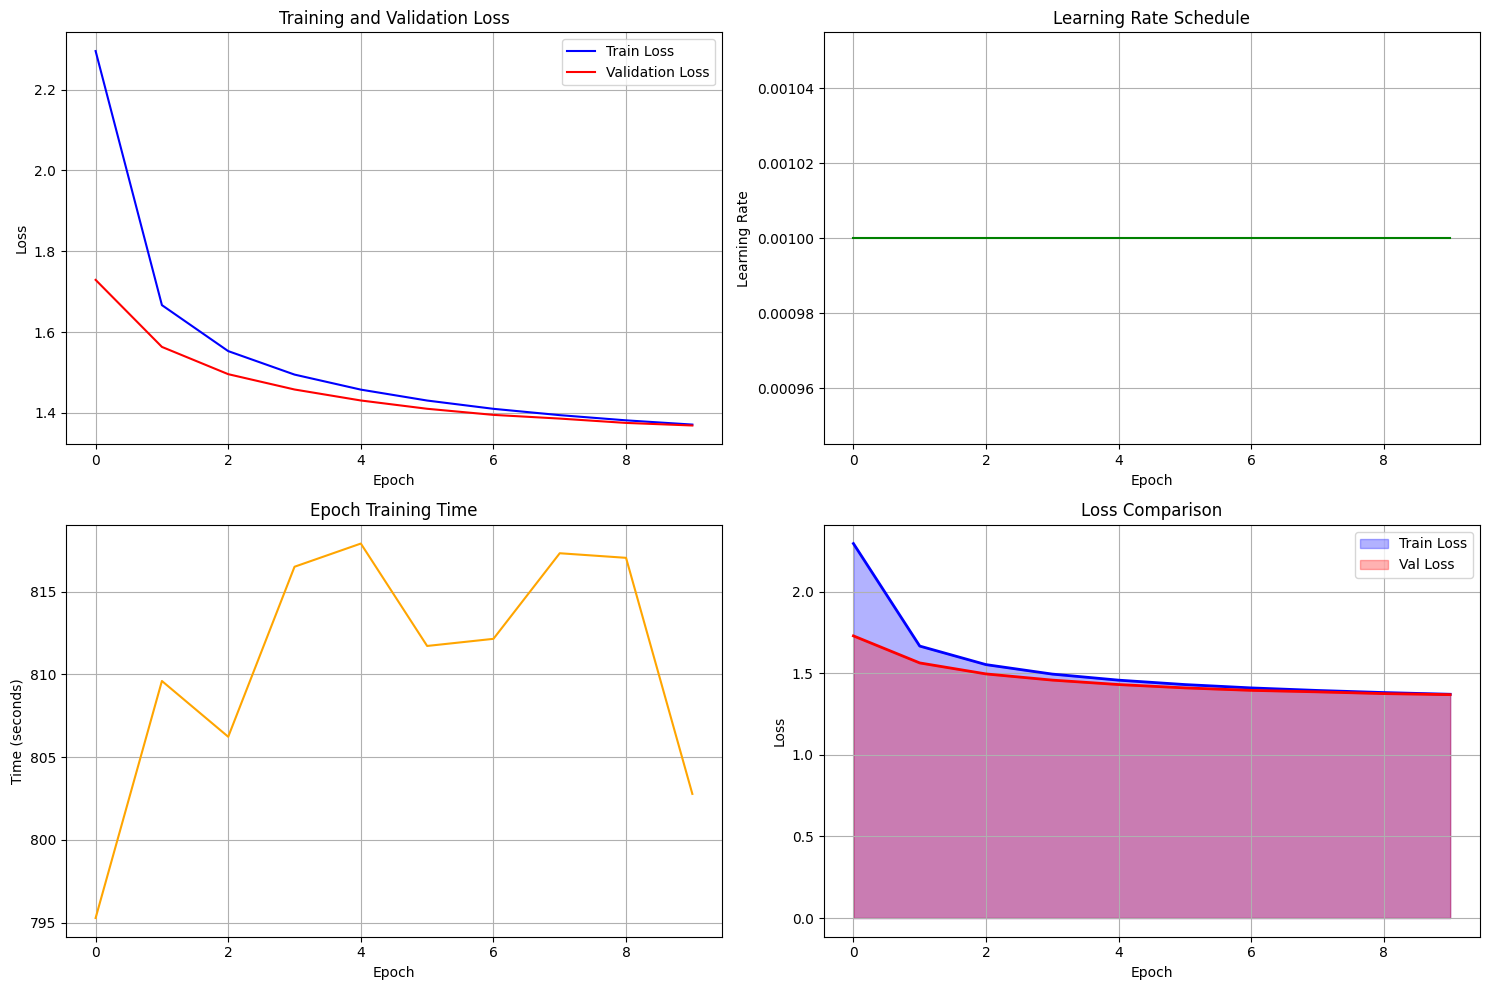

In [4]:
# Train the model with comprehensive training loop

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Trainer:
    """
    Trainer class for Seq2Seq machine translation model
    """
    def __init__(self, model, train_dataloader, val_dataloader, device, 
                 learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        
        # Loss function - ignore padding tokens (index 0)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')
        
        # Optimizer
        self.optimizer = optim.Adam(model.parameters(), 
                                  lr=learning_rate, 
                                  weight_decay=weight_decay)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        
        # Training history
        self.history = defaultdict(list)
        
    def calculate_loss(self, outputs, targets, target_lengths=None):
        """Calculate loss for the batch"""
        # Reshape for loss calculation (use reshape instead of view for non-contiguous tensors)
        outputs_flat = outputs.reshape(-1, outputs.size(-1))
        targets_flat = targets.reshape(-1)
        
        # Calculate loss
        loss = self.criterion(outputs_flat, targets_flat)
        
        return loss
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            source_ids = batch['source_ids'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass with teacher forcing
            decoder_input = target_ids[:, :-1]  # Remove last token
            decoder_targets = target_ids[:, 1:]  # Remove first token (BOS)
            
            outputs = self.model(source_ids, decoder_input)
            
            # Calculate loss
            loss = self.calculate_loss(outputs, decoder_targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update parameters
            self.optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_loss / num_batches:.4f}'
            })
            
            # Memory cleanup
            if batch_idx % 100 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return epoch_loss / num_batches
    
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(self.val_dataloader, desc="Validation", leave=False)
        
        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                source_ids = batch['source_ids'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)
                
                # Forward pass
                decoder_input = target_ids[:, :-1]
                decoder_targets = target_ids[:, 1:]
                
                outputs = self.model(source_ids, decoder_input)
                
                # Calculate loss
                loss = self.calculate_loss(outputs, decoder_targets)
                
                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1
                
                # Update progress bar
                progress_bar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'Avg Val Loss': f'{epoch_loss / num_batches:.4f}'
                })
        
        return epoch_loss / num_batches
    
    def train(self, num_epochs=10, save_path=None):
        """Train the model for specified number of epochs"""
        print(f"=== Starting Training for {num_epochs} Epochs ===")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_dataloader)}")
        print(f"Validation batches: {len(self.val_dataloader)}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print("=" * 60)
        
        best_val_loss = float('inf')
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)
            
            # Train
            train_loss = self.train_epoch()
            
            # Validate
            val_loss = self.validate_epoch()
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time
            
            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch_time'].append(epoch_time)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Epoch Time: {epoch_time:.2f}s")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best validation loss: {best_val_loss:.4f}")
                
                if save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'model_config': model_config
                    }, save_path)
                    print(f"Model saved to {save_path}")
            
            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Training summary
        total_time = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} min)")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {self.history['val_loss'][-1]:.4f}")
        
        return self.history
    
    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot learning rate
        axes[0, 1].plot(self.history['learning_rate'], color='green')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True)
        
        # Plot epoch time
        axes[1, 0].plot(self.history['epoch_time'], color='orange')
        axes[1, 0].set_title('Epoch Training Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True)
        
        # Plot loss comparison
        x = range(len(self.history['train_loss']))
        axes[1, 1].fill_between(x, self.history['train_loss'], alpha=0.3, color='blue', label='Train Loss')
        axes[1, 1].fill_between(x, self.history['val_loss'], alpha=0.3, color='red', label='Val Loss')
        axes[1, 1].plot(self.history['train_loss'], color='blue', linewidth=2)
        axes[1, 1].plot(self.history['val_loss'], color='red', linewidth=2)
        axes[1, 1].set_title('Loss Comparison')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=1e-3,
    weight_decay=1e-5
)

# Start training for 10 epochs
print("Starting training...")
history = trainer.train(num_epochs=10, save_path="best_seq2seq_attention_model.pth")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history()
